In [3]:
import os
import numpy as np
import imageio.v2 as imageio

# --- 1. 配置参数 ---
# !!! 请务必修改为您的实际路径 !!!
IMAGE_FOLDER = r'C:\Users\Alpaca_YT\pythonSet\_12.72um_LADAF-2020-31_heart_ROI-06_pag-0.02_0.03_jp2_' 
OUTPUT_FOLDER = r'C:\Users\Alpaca_YT\pythonSet\heart_slices'

# 根据您的数据信息设定
TOTAL_SLICES_IN_STACK = 4688
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1920

# 我们要构建的数据集参数
ROI_Z_SLICES = 256
ROI_XY_SIZE = 512
PATCH_SIZE = 256
JPG_QUALITY = 95 # JPG图片质量

# --- 辅助函数：将16位图像数据缩放到8位 ---
def scale_to_8bit(image_16bit):
    """将16位灰度图（0-65535）线性缩放到8位（0-255）"""
    # 如果图像数据已经是0，直接返回，避免除以0的错误
    if image_16bit.max() == image_16bit.min():
        return np.zeros(image_16bit.shape, dtype=np.uint8)
    
    # 线性缩放
    scaled_image = ((image_16bit - image_16bit.min()) / (image_16bit.max() - image_16bit.min())) * 255.0
    return scaled_image.astype(np.uint8)

# --- 2. 主逻辑 ---
def create_dataset():
    print("开始创建数据集...")
    
    # --- 步骤 2.1: 定位文件并创建输出目录 ---
    all_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jp2')])
    if len(all_files) != TOTAL_SLICES_IN_STACK:
        print(f"警告: 文件夹中的文件数量({len(all_files)})与设定的总数({TOTAL_SLICES_IN_STACK})不符。")
        return

    # 计算中间切片的索引
    center_z = TOTAL_SLICES_IN_STACK // 2
    start_z = center_z - (ROI_Z_SLICES // 2)
    end_z = start_z + ROI_Z_SLICES
    files_to_load = all_files[start_z:end_z]
    
    # 创建输出文件夹
    group_folders = {
        'group1_xy_top_left': os.path.join(OUTPUT_FOLDER, 'group1_xy_top_left'),
        'group2_xy_bottom_right': os.path.join(OUTPUT_FOLDER, 'group2_xy_bottom_right'),
        'group3_yz_top': os.path.join(OUTPUT_FOLDER, 'group3_yz_top'),
        'group4_yz_bottom': os.path.join(OUTPUT_FOLDER, 'group4_yz_bottom')
    }
    for folder in group_folders.values():
        os.makedirs(folder, exist_ok=True)
        
    print(f"将从索引 {start_z} 到 {end_z-1} 加载 {len(files_to_load)} 张切片。")

    # --- 步骤 2.2: 加载并裁剪数据，构建3D数据块 ---
    # 计算XY平面的裁剪区域
    center_x, center_y = ORIGINAL_WIDTH // 2, ORIGINAL_HEIGHT // 2
    start_x = center_x - (ROI_XY_SIZE // 2)
    end_x = start_x + ROI_XY_SIZE
    start_y = center_y - (ROI_XY_SIZE // 2)
    end_y = start_y + ROI_XY_SIZE

    # 创建一个空的3D数组来存储我们的ROI
    volume_roi = np.zeros((ROI_Z_SLICES, ROI_XY_SIZE, ROI_XY_SIZE), dtype=np.uint16)

    print("正在加载和裁剪原始图像以构建3D数据块...")
    for i, fname in enumerate(files_to_load):
        if (i+1) % 50 == 0:
            print(f"  正在处理第 {i+1}/{ROI_Z_SLICES} 张原始切片...")
        img_path = os.path.join(IMAGE_FOLDER, fname)
        full_slice = imageio.imread(img_path)
        # 裁剪中心区域并存入3D数据块
        volume_roi[i, :, :] = full_slice[start_y:end_y, start_x:end_x]
        
    print(f"3D数据块构建完成，维度: {volume_roi.shape}") # 应该是 (256, 512, 512)

    # --- 步骤 2.3: 生成并保存XY切片组 ---
    print("正在生成和保存XY切片...")
    for z in range(ROI_Z_SLICES):
        slice_512 = volume_roi[z, :, :]
        
        # 提取左上角和右下角的256x256部分
        patch_tl = slice_512[0:PATCH_SIZE, 0:PATCH_SIZE]
        patch_br = slice_512[PATCH_SIZE:ROI_XY_SIZE, PATCH_SIZE:ROI_XY_SIZE]

        # 缩放并保存
        imageio.imwrite(os.path.join(group_folders['group1_xy_top_left'], f'xy_tl_{z:04d}.jpg'), scale_to_8bit(patch_tl), quality=JPG_QUALITY)
        imageio.imwrite(os.path.join(group_folders['group2_xy_bottom_right'], f'xy_br_{z:04d}.jpg'), scale_to_8bit(patch_br), quality=JPG_QUALITY)

    print("XY切片组已保存。")

    # --- 步骤 2.4: 生成并保存YZ切片组 ---
    # volume_roi 的维度是 (Z, Y, X)
    print("正在生成和保存YZ切片...")
    for i, x in enumerate(range(0, ROI_XY_SIZE, 2)): # 每隔一个像素提取一张，共256张
        # 提取YZ平面切片，维度是 (Z, Y)
        slice_yz = volume_roi[:, :, x]
        # 交换轴以得到 (Y, Z) 方便处理
        slice_yz = slice_yz.T # 现在维度是 (Y, Z) = (512, 256)
        
        # 提取上半部分和下半部分
        patch_top = slice_yz[0:PATCH_SIZE, 0:PATCH_SIZE]
        patch_bottom = slice_yz[PATCH_SIZE:ROI_XY_SIZE, 0:PATCH_SIZE]
        
        # 缩放并保存
        imageio.imwrite(os.path.join(group_folders['group3_yz_top'], f'yz_top_{i:04d}.jpg'), scale_to_8bit(patch_top), quality=JPG_QUALITY)
        imageio.imwrite(os.path.join(group_folders['group4_yz_bottom'], f'yz_bottom_{i:04d}.jpg'), scale_to_8bit(patch_bottom), quality=JPG_QUALITY)

    print("YZ切片组已保存。")
    print("\n数据集构建完成！所有文件已保存在文件夹: " + OUTPUT_FOLDER)

# --- 运行主函数 ---
if __name__ == '__main__':
    create_dataset()

开始创建数据集...
将从索引 2216 到 2471 加载 256 张切片。
正在加载和裁剪原始图像以构建3D数据块...
  正在处理第 50/256 张原始切片...
  正在处理第 100/256 张原始切片...
  正在处理第 150/256 张原始切片...
  正在处理第 200/256 张原始切片...
  正在处理第 250/256 张原始切片...
3D数据块构建完成，维度: (256, 512, 512)
正在生成和保存XY切片...
XY切片组已保存。
正在生成和保存YZ切片...
YZ切片组已保存。

数据集构建完成！所有文件已保存在文件夹: C:\Users\Alpaca_YT\pythonSet\heart_slices


In [2]:
import os
import numpy as np
import imageio.v2 as imageio
import random

# --- 1. 配置参数 ---
# !!! 请务必修改为您的实际路径 !!!
IMAGE_FOLDER = r'C:\Users\Alpaca_YT\pythonSet\_12.72um_LADAF-2020-31_heart_ROI-06_pag-0.02_0.03_jp2_' 
OUTPUT_FOLDER = './heart_slices_dataset'

# 原始数据信息
TOTAL_SLICES_IN_STACK = 4688
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1920

# 目标参数
NUM_RANDOM_BLOCKS = 16
BLOCK_SIZE = 256
SLICES_PER_BLOCK_XY = 64
SLICES_PER_BLOCK_YZ = 64
JPG_QUALITY = 95

# ***** 新增：定义XY平面的采样边界 *****
XY_SAMPLING_BOUNDS = (400, 1520)

# --- 辅助函数：将16位图像数据缩放到8位 ---
def scale_to_8bit(image_16bit):
    """将16位灰度图（0-65535）线性缩放到8位（0-255）"""
    if image_16bit.max() == image_16bit.min():
        return np.zeros(image_16bit.shape, dtype=np.uint8)
    scaled_image = ((image_16bit - image_16bit.min()) / (image_16bit.max() - image_16bit.min())) * 255.0
    return scaled_image.astype(np.uint8)

# --- 2. 主逻辑 ---
def create_constrained_dataset():
    print("开始创建中心区域约束的随机数据集...")

    all_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jp2')])
    if len(all_files) == 0:
        print(f"错误: 在 {IMAGE_FOLDER} 中未找到.jp2文件")
        return

    xy_output_folder = os.path.join(OUTPUT_FOLDER, 'heart_slice_xy')
    yz_output_folder = os.path.join(OUTPUT_FOLDER, 'heart_slice_yz')
    os.makedirs(xy_output_folder, exist_ok=True)
    os.makedirs(yz_output_folder, exist_ok=True)
    print(f"所有XY切片将保存到: {xy_output_folder}")
    print(f"所有YZ切片将保存到: {yz_output_folder}")

    # --- 外层循环：提取8个随机块 ---
    for block_num in range(1, NUM_RANDOM_BLOCKS + 1):
        print(f"\n--- 正在处理随机块 #{block_num}/{NUM_RANDOM_BLOCKS} ---")

        # --- 步骤 2.1: 为当前块确定一个随机的起始位置 ---
        # ***** 修改部分开始 *****
        # Z轴保持完全随机
        rand_z_start = random.randint(0, TOTAL_SLICES_IN_STACK - BLOCK_SIZE)

        # XY轴在指定的中心区域内随机
        xy_min_coord = XY_SAMPLING_BOUNDS[0]
        xy_max_coord = XY_SAMPLING_BOUNDS[1] - BLOCK_SIZE # 计算起始点的最大有效值
        
        rand_y_start = random.randint(xy_min_coord, xy_max_coord)
        rand_x_start = random.randint(xy_min_coord, xy_max_coord)
        # ***** 修改部分结束 *****
        
        print(f"随机块起始坐标 (Z, Y, X): ({rand_z_start}, {rand_y_start}, {rand_x_start})")

        # --- 步骤 2.2: 加载并裁剪数据，构建3D数据块 ---
        block_volume = np.zeros((BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE), dtype=np.uint16)
        files_to_load = all_files[rand_z_start : rand_z_start + BLOCK_SIZE]
        
        print("  正在从磁盘加载数据以构建3D块...")
        for i, fname in enumerate(files_to_load):
            img_path = os.path.join(IMAGE_FOLDER, fname)
            full_slice = imageio.imread(img_path)
            block_volume[i, :, :] = full_slice[rand_y_start : rand_y_start + BLOCK_SIZE,
                                               rand_x_start : rand_x_start + BLOCK_SIZE]
        
        print(f"  3D数据块构建完成，维度: {block_volume.shape}")

        # --- 步骤 2.3: 从块中提取并保存XY和YZ切片 ---
        print(f"  正在从块中提取并保存 {SLICES_PER_BLOCK_XY}张XY 和 {SLICES_PER_BLOCK_YZ}张YZ 切片...")
        
        for i, z_idx in enumerate(np.linspace(0, BLOCK_SIZE-1, SLICES_PER_BLOCK_XY).astype(int)):
            patch = block_volume[z_idx, :, :]
            filename = f'block{block_num:02d}_xy_{i:03d}.jpg'
            imageio.imwrite(os.path.join(xy_output_folder, filename), scale_to_8bit(patch), quality=JPG_QUALITY)

        for i, x_idx in enumerate(np.linspace(0, BLOCK_SIZE-1, SLICES_PER_BLOCK_YZ).astype(int)):
            patch = block_volume[:, :, x_idx]
            filename = f'block{block_num:02d}_yz_{i:03d}.jpg'
            imageio.imwrite(os.path.join(yz_output_folder, filename), scale_to_8bit(patch), quality=JPG_QUALITY)
            
        print(f"  随机块 #{block_num} 处理完毕。")

    print("\n数据集构建完成！")


# --- 运行主函数 ---
if __name__ == '__main__':
    create_constrained_dataset()

开始创建中心区域约束的随机数据集...
所有XY切片将保存到: ./heart_slices_dataset\heart_slice_xy
所有YZ切片将保存到: ./heart_slices_dataset\heart_slice_yz

--- 正在处理随机块 #1/16 ---
随机块起始坐标 (Z, Y, X): (4240, 642, 731)
  正在从磁盘加载数据以构建3D块...
  3D数据块构建完成，维度: (256, 256, 256)
  正在从块中提取并保存 64张XY 和 64张YZ 切片...
  随机块 #1 处理完毕。

--- 正在处理随机块 #2/16 ---
随机块起始坐标 (Z, Y, X): (1222, 509, 740)
  正在从磁盘加载数据以构建3D块...
  3D数据块构建完成，维度: (256, 256, 256)
  正在从块中提取并保存 64张XY 和 64张YZ 切片...
  随机块 #2 处理完毕。

--- 正在处理随机块 #3/16 ---
随机块起始坐标 (Z, Y, X): (1078, 504, 716)
  正在从磁盘加载数据以构建3D块...
  3D数据块构建完成，维度: (256, 256, 256)
  正在从块中提取并保存 64张XY 和 64张YZ 切片...
  随机块 #3 处理完毕。

--- 正在处理随机块 #4/16 ---
随机块起始坐标 (Z, Y, X): (2353, 512, 513)
  正在从磁盘加载数据以构建3D块...
  3D数据块构建完成，维度: (256, 256, 256)
  正在从块中提取并保存 64张XY 和 64张YZ 切片...
  随机块 #4 处理完毕。

--- 正在处理随机块 #5/16 ---
随机块起始坐标 (Z, Y, X): (1231, 764, 624)
  正在从磁盘加载数据以构建3D块...
  3D数据块构建完成，维度: (256, 256, 256)
  正在从块中提取并保存 64张XY 和 64张YZ 切片...
  随机块 #5 处理完毕。

--- 正在处理随机块 #6/16 ---
随机块起始坐标 (Z, Y, X): (4185, 400, 585)
  正在从磁盘加载数据以构建3D块...


In [9]:
import os
import numpy as np
import imageio.v2 as imageio
import random
from tqdm import tqdm # 引入tqdm来显示进度条

# --- 1. 配置参数 ---
# !!! 请务必修改为您的实际路径 !!!
IMAGE_FOLDER = r'C:\Users\Alpaca_YT\pythonSet\_12.72um_LADAF-2020-31_heart_ROI-06_pag-0.02_0.03_jp2_' 
OUTPUT_FOLDER = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy" 

# 原始数据信息
TOTAL_SLICES_IN_STACK = 4688
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1920

# 目标参数
# 设定进行多少次“随机选层-裁剪”的操作
# 每次操作会生成4张256x256的图片
# 例如，256次操作会生成 256 * 4 = 1024 张最终切片
NUM_RANDOM_SAMPLING_EVENTS = 256

# XY平面的采样边界 和 裁剪尺寸
XY_SAMPLING_BOUNDS = (400, 1520)
CROP_SIZE_512 = 512
PATCH_SIZE_256 = 256
JPG_QUALITY = 95

# --- 辅助函数：将16位图像数据缩放到8位 (保持不变) ---
def scale_to_8bit(image_16bit):
    """将16位灰度图（0-65535）线性缩放到8位（0-255）"""
    if image_16bit.max() == image_16bit.min():
        return np.zeros(image_16bit.shape, dtype=np.uint8)
    scaled_image = ((image_16bit - image_16bit.min()) / (image_16bit.max() - image_16bit.min())) * 255.0
    return scaled_image.astype(np.uint8)

# --- 2. 主逻辑 ---
def create_diverse_xy_dataset():
    print("开始创建高度多样性的XY平面数据集...")

    all_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith('.jp2')])
    if len(all_files) == 0:
        print(f"错误: 在 {IMAGE_FOLDER} 中未找到.jp2文件")
        return

    # 创建输出文件夹
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    print(f"所有切片将保存到: {OUTPUT_FOLDER}")

    # --- 主循环：执行N次随机采样事件 ---
    # 使用tqdm来包装循环，可以实时看到进度
    for event_idx in tqdm(range(NUM_RANDOM_SAMPLING_EVENTS), desc="生成随机切片中"):

        # 步骤1: 随机选择一张原始切片
        random_z_index = random.randint(0, TOTAL_SLICES_IN_STACK - 1)
        target_filename = all_files[random_z_index]
        img_path = os.path.join(IMAGE_FOLDER, target_filename)
        full_slice = imageio.imread(img_path)

        # 步骤2: 在[400, 1520]约束内，随机确定512x512裁剪区域的左上角坐标
        min_coord = XY_SAMPLING_BOUNDS[0]
        max_coord_start = XY_SAMPLING_BOUNDS[1] - CROP_SIZE_512
        
        rand_y_start = random.randint(min_coord, max_coord_start)
        rand_x_start = random.randint(min_coord, max_coord_start)

        # 裁剪出512x512的区域
        crop_512 = full_slice[rand_y_start : rand_y_start + CROP_SIZE_512,
                              rand_x_start : rand_x_start + CROP_SIZE_512]

        # 步骤3: 将512x512区域精确切割成4个256x256的块
        patch_tl = crop_512[0:PATCH_SIZE_256, 0:PATCH_SIZE_256] # 左上 (Top-Left)
        patch_tr = crop_512[0:PATCH_SIZE_256, PATCH_SIZE_256:CROP_SIZE_512] # 右上 (Top-Right)
        patch_bl = crop_512[PATCH_SIZE_256:CROP_SIZE_512, 0:PATCH_SIZE_256] # 左下 (Bottom-Left)
        patch_br = crop_512[PATCH_SIZE_256:CROP_SIZE_512, PATCH_SIZE_256:CROP_SIZE_512] # 右下 (Bottom-Right)

        # 步骤4: 保存这4个块，使用包含来源信息的文件名
        patches = {
            'tl': patch_tl, 'tr': patch_tr,
            'bl': patch_bl, 'br': patch_br
        }

        for quadrant, patch_data in patches.items():
            # 文件名格式: z[来源切片号]_evt[事件号]_[象限].jpg -> e.g., z3108_evt025_tl.jpg
            filename = f"z{random_z_index:04d}_evt{event_idx:03d}_{quadrant}.jpg"
            output_path = os.path.join(OUTPUT_FOLDER, filename)
            imageio.imwrite(output_path, scale_to_8bit(patch_data), quality=JPG_QUALITY)

    total_generated = NUM_RANDOM_SAMPLING_EVENTS * 4
    print(f"\n数据集构建完成！共生成 {total_generated} 张图片。")

# --- 运行主函数 ---
if __name__ == '__main__':
    create_diverse_xy_dataset()

# 如果在Jupyter Notebook中直接运行，可以取消下面这行的注释
# create_diverse_xy_dataset()

开始创建高度多样性的XY平面数据集...
所有切片将保存到: C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy


生成随机切片中: 100%|██████████| 256/256 [00:35<00:00,  7.15it/s]


数据集构建完成！共生成 1024 张图片。


In [10]:
# 步骤 1: 确保已安装必要的库
# !pip install scipy

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import linalg
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms import ToTensor 
# ----------------------------------------
# 1. 定义特征提取器和辅助函数 (保持不变)
# ----------------------------------------
class InceptionV3FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.feature_layer = self.inception.avgpool
        self.inception.eval()
        self.features = None
        self.feature_layer.register_forward_hook(self.save_features_hook)
    def save_features_hook(self, module, input, output):
        self.features = output
    def forward(self, x):
        x_resized = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        self.inception(x_resized)
        return self.features.view(x.shape[0], -1)

def get_activations(dataloader, model, device):
    model.eval()
    activations = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="提取激活值"):
            batch = batch.to(device)
            act = model(batch)
            activations.append(act.cpu().numpy())
    return np.concatenate(activations, axis=0)

def calculate_statistics(activations):
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean))

# ----------------------------------------
# 2. 准备数据 (此处进行修改)
# ----------------------------------------
base_folder_xy = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
test_folder_yz = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz"

# --- 准备训练集和验证集文件列表 ---
all_xy_fns = sorted([f for f in os.listdir(base_folder_xy) if f.lower().endswith(".jpg")])
all_xy_indices = list(range(len(all_xy_fns)))
train_idxs, val_idxs = train_test_split(all_xy_indices, test_size=0.25, random_state=42)
train_files = [all_xy_fns[i] for i in train_idxs]
val_files = [all_xy_fns[i] for i in val_idxs]

# --- 准备测试集文件列表 ---
all_test_fns = sorted([f for f in os.listdir(test_folder_yz) if f.lower().endswith(".jpg")])

# --- 定义Dataset类 ---
class ImageListDataset(Dataset):
    def __init__(self, folder_path, file_list, transform=None):
        self.folder_path = folder_path
        self.file_list = file_list
        self.transform = transform or ToTensor()
    def __len__(self): return len(self.file_list)
    def __getitem__(self, idx):
        # 这里的 self.file_list[idx] 现在是正确的文件名字符串
        img_path = os.path.join(self.folder_path, self.file_list[idx])
        return self.transform(Image.open(img_path).convert("RGB"))

# --- 实例化所有Dataset ---
train_dataset = ImageListDataset(base_folder_xy, train_files)
val_dataset = ImageListDataset(base_folder_xy, val_files)
# ### 核心修正：创建 test_dataset 时，传入文件名列表 all_test_fns ###
test_dataset = ImageListDataset(test_folder_yz, all_test_fns)

# ----------------------------------------
# 3. 执行计算 (保持不变)
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
feature_extractor = InceptionV3FeatureExtractor().to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

print("--- 开始手动计算FID分数 ---")

print("\n处理训练集...")
act_train = get_activations(train_loader, feature_extractor, device)
mu_train, sigma_train = calculate_statistics(act_train)

print("\n处理验证集...")
act_val = get_activations(val_loader, feature_extractor, device)
mu_val, sigma_val = calculate_statistics(act_val)

print("\n处理测试集...")
act_test = get_activations(test_loader, feature_extractor, device)
mu_test, sigma_test = calculate_statistics(act_test)

print("\n--- 计算最终FID分数 ---")

fid_train_val = calculate_frechet_distance(mu_train, sigma_train, mu_val, sigma_val)
print(f"-> FID (训练集 vs 验证集): {fid_train_val:.4f}")

fid_train_test = calculate_frechet_distance(mu_train, sigma_train, mu_test, sigma_test)
print(f"-> FID (训练集 vs 测试集): {fid_train_test:.4f}")

fid_val_test = calculate_frechet_distance(mu_val, sigma_val, mu_test, sigma_test)
print(f"-> FID (验证集 vs 测试集): {fid_val_test:.4f}")

--- 开始手动计算FID分数 ---

处理训练集...


提取激活值: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]



处理验证集...


提取激活值: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]



处理测试集...


提取激活值: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]



--- 计算最终FID分数 ---
-> FID (训练集 vs 验证集): 39.6305
-> FID (训练集 vs 测试集): 75.6572
-> FID (验证集 vs 测试集): 87.1529


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
import timm

# ----------------------------------------
# 1. 设置和数据加载部分 (保持不变)
# ----------------------------------------
# (此处省略与上次相同的 Dataset 定义和数据加载代码，以保持简洁)
patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
output_model_dir = "Train_SwinUnet_v2_heart" # 使用新的文件夹以避免混淆
os.makedirs(output_model_dir, exist_ok=True)
num_epochs = 15
batch_size = 8
learning_rate = 1e-4

all_fns = sorted([f for f in os.listdir(patches_folder) if f.lower().endswith(".jpg")])
all_indices = list(range(len(all_fns)))
train_idxs, val_idxs = train_test_split(all_indices, test_size=0.25, random_state=42)

class RotLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns) * 2
    def __getitem__(self, idx):
        img_idx, rot_flag = idx // 2, idx % 2
        fn = self.fns[img_idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        if rot_flag == 1: arr = np.rot90(arr, k=1)
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t


# ----------------------------------------
# 2. 定义修正后的 SwinUnet 模型
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels() # -> [96, 192, 384, 768]
        
        # --- 解码器现在有4个完整的上采样+卷积阶段 ---
        self.up4 = UpBlockPixelShuffle(encoder_channels[3], 512)
        self.dec4 = DoubleConv(encoder_channels[2] + 512, 512)
        
        self.up3 = UpBlockPixelShuffle(512, 256)
        self.dec3 = DoubleConv(encoder_channels[1] + 256, 256)
        
        self.up2 = UpBlockPixelShuffle(256, 128)
        self.dec2 = DoubleConv(encoder_channels[0] + 128, 128)
        
        self.up1 = UpBlockPixelShuffle(128, 64)
        # 最后的卷积块，输入通道数 = 上一层输出(64) + 原始输入(in_ch)
        self.dec1 = DoubleConv(64 + in_ch, 64)
        
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        x_orig = x # 保存原始输入用于最终的跳跃连接
        
        # 预处理输入以匹配预训练模型
        if self.in_ch == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # ---- 编码器 ----
        features = self.encoder(x)
        e1 = features[0].permute(0, 3, 1, 2)
        e2 = features[1].permute(0, 3, 1, 2)
        e3 = features[2].permute(0, 3, 1, 2)
        e4 = features[3].permute(0, 3, 1, 2)
        
        # ---- 解码器 ----
        # 8x8 -> 16x16
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        
        # 16x16 -> 32x32
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        
        # 32x32 -> 64x64
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        
        # 64x64 -> 128x128
        u1 = self.up1(d2)
        
        # ### 核心修改：最后的上采样，将128x128 -> 256x256 ###
        # 我们需要再做一次上采样来匹配原始图像尺寸
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        
        # 与原始输入进行跳跃连接
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        
        out = self.outc(d1)
        return out

# ----------------------------------------
# 3. 准备训练 (保持不变)
# ----------------------------------------
transform = transforms.ToTensor()
train_dataset = RotLowHighDataset(patches_folder, train_idxs, all_fns, transform)
val_dataset = PlainLowHighDataset(patches_folder, val_idxs, all_fns, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUnet(in_ch=1, out_ch=1, pretrained=True).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# ----------------------------------------
# 4. 训练循环 (保持不变)
# ----------------------------------------
# ----------------------------------------
# 准备 Dataloader, 模型, 优化器 (保持不变)
# ----------------------------------------
# (此处假设之前的代码已定义好 model, optimizer, train_loader, val_loader, device 等变量)
# criterion 仍然是基础的MSE损失
criterion = nn.MSELoss()

# ### 修改点 1：定义高频损失所需组件 ###
# 定义拉普拉斯卷积核，并将其发送到正确的设备
laplacian_kernel = torch.tensor(
    [[0.0, -1.0, 0.0],
     [-1.0, 4.0, -1.0],
     [0.0, -1.0, 0.0]],
    device=device, dtype=torch.float32
).view(1, 1, 3, 3)

# 定义高频损失的权重
lambda_hf = 0.5

# 定义高频损失函数
def high_freq_loss(pred, target):
    """计算预测和目标之间高频分量的MSE损失"""
    pred_lap = F.conv2d(pred, laplacian_kernel, padding=1)
    tgt_lap  = F.conv2d(target, laplacian_kernel, padding=1)
    return F.mse_loss(pred_lap, tgt_lap)


# ----------------------------------------
# 训练循环 (修改损失计算部分)
# ----------------------------------------
print(f"开始在 {device} 上训练最终修正版的 SwinUnet (使用高频加权损失)...")
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(inp)
        
        # ### 修改点 2：计算复合损失 ###
        mse_train = criterion(out, tgt)
        hf_train = high_freq_loss(out, tgt)
        loss = mse_train + lambda_hf * hf_train # 总损失 = MSE + λ * 高频损失
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inp.size(0)
    avg_train_loss = train_loss / len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inp_v, tgt_v in val_loader:
            inp_v, tgt_v = inp_v.to(device), tgt_v.to(device)
            out_v = model(inp_v)
            
            # ### 修改点 3：在验证时也使用相同的复合损失 ###
            mse_val = criterion(out_v, tgt_v)
            hf_val = high_freq_loss(out_v, tgt_v)
            loss_v = mse_val + lambda_hf * hf_val

            val_loss += loss_v.item() * inp_v.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # 保存模型权重时，可以加上标识，例如 "hf" 代表 high-frequency
    ckpt_path = os.path.join(output_model_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    torch.save(model.state_dict(), ckpt_path)

print(f"\n训练完毕，所有模型已保存在 '{output_model_dir}/'")


开始在 cuda 上训练最终修正版的 SwinUnet (使用高频加权损失)...
Epoch 01/15 | Train Loss: 0.053307 | Val Loss: 0.029927
Epoch 02/15 | Train Loss: 0.031038 | Val Loss: 0.029115
Epoch 03/15 | Train Loss: 0.029726 | Val Loss: 0.028878
Epoch 04/15 | Train Loss: 0.029251 | Val Loss: 0.028659
Epoch 05/15 | Train Loss: 0.029762 | Val Loss: 0.028835
Epoch 06/15 | Train Loss: 0.028885 | Val Loss: 0.028444
Epoch 07/15 | Train Loss: 0.028839 | Val Loss: 0.028361
Epoch 08/15 | Train Loss: 0.028575 | Val Loss: 0.029726
Epoch 09/15 | Train Loss: 0.028772 | Val Loss: 0.028277
Epoch 10/15 | Train Loss: 0.028551 | Val Loss: 0.028314
Epoch 11/15 | Train Loss: 0.028593 | Val Loss: 0.032690
Epoch 12/15 | Train Loss: 0.028772 | Val Loss: 0.028568
Epoch 13/15 | Train Loss: 0.028329 | Val Loss: 0.028835
Epoch 14/15 | Train Loss: 0.028297 | Val Loss: 0.028204
Epoch 15/15 | Train Loss: 0.028318 | Val Loss: 0.028232

训练完毕，所有模型已保存在 'Train_SwinUnet_v2_heart/'


In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import timm

# ----------------------------------------
# 1. 定义与训练时完全一致的模型和 Dataset 类
# ----------------------------------------

# ### 核心修正：修复 DoubleConv 模块的定义 ###
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            # 第二个卷积的输入通道应该是第一个卷积的输出通道
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True)
        )
    def forward(self, x): 
        return self.net(x)

# (SwinUnet 和其他辅助类的定义保持不变)
class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        
        self.up4 = UpBlockPixelShuffle(encoder_channels[3], 512)
        self.dec4 = DoubleConv(encoder_channels[2] + 512, 512)
        self.up3 = UpBlockPixelShuffle(512, 256)
        self.dec3 = DoubleConv(encoder_channels[1] + 256, 256)
        self.up2 = UpBlockPixelShuffle(256, 128)
        self.dec2 = DoubleConv(encoder_channels[0] + 128, 128)
        self.up1 = UpBlockPixelShuffle(128, 64)
        self.dec1 = DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        x_orig = x
        if self.in_ch == 1:
            x = x.repeat(1, 3, 1, 1)
        
        features = self.encoder(x)
        e1 = features[0].permute(0, 3, 1, 2)
        e2 = features[1].permute(0, 3, 1, 2)
        e3 = features[2].permute(0, 3, 1, 2)
        e4 = features[3].permute(0, 3, 1, 2)
        
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        
        out = self.outc(d1)
        return out

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder = patches_folder
        self.transform = transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

# ----------------------------------------
# 2. 设置路径，准备 Dataloader (保持不变)
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith(".jpg")])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith(".jpg")])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 加载训练好的模型权重 (保持不变)
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device)
checkpoint_path = r"Train_SwinUnet_v2_heart/SwinUnet_v2_hf_epoch15.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 定义评估函数 (保持不变)
# ----------------------------------------
def evaluate_model(loader, model_to_test):
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t = inp_t.to(device)
            out_t = model_to_test(inp_t)
            
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.squeeze().numpy()
            
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            count += 1
            
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    return avg_psnr, avg_ssim

# ----------------------------------------
# 5. 执行评估并打印结果 (保持不变)
# ----------------------------------------
print(f"\n在 {device} 上评估模型...")

val_psnr, val_ssim = evaluate_model(val_loader, model)
print(f"\n-> 验证集结果 (来自 train_patches_XY 的 25%):")
print(f"   - 平均 PSNR: {val_psnr:.4f} dB")
print(f"   - 平均 SSIM: {val_ssim:.4f}")

test_psnr, test_ssim = evaluate_model(test_loader, model)
print(f"\n-> 测试集结果 (来自 test_patches_YZ):")
print(f"   - 平均 PSNR: {test_psnr:.4f} dB")
print(f"   - 平均 SSIM: {test_ssim:.4f}")

C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_4536\3453698110.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_l

成功加载模型权重: Train_SwinUnet_v2_heart/SwinUnet_v2_hf_epoch15.pth

在 cuda 上评估模型...

-> 验证集结果 (来自 train_patches_XY 的 25%):
   - 平均 PSNR: 22.8712 dB
   - 平均 SSIM: 0.4825

-> 测试集结果 (来自 test_patches_YZ):
   - 平均 PSNR: 22.5529 dB
   - 平均 SSIM: 0.4410


C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


开始在 cuda 上评估 'Train_SwinUnet_v2_heart' 的所有模型...


评估进度:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_27556\1191888571.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load


--- 评估结果汇总 ---
Epoch     Val PSNR       Val SSIM       Test PSNR      Test SSIM      
------------------------------------------------------------
1         21.6691        0.3866         22.0974        0.3710         
2         21.8826        0.4329         22.2886        0.4134         
3         21.7702        0.4408         22.0510        0.4174         
4         21.8415        0.4483         22.2231        0.4276         
5         21.9400        0.4431         22.2675        0.4154         
6         22.0662        0.4545         22.4438        0.4335         
7         22.1181        0.4568         22.5037        0.4352         
8         21.1367        0.4498         21.1936        0.4250         
9         22.0915        0.4670         22.4142        0.4466         
10        22.1539        0.4604         22.5254        0.4385         
11        20.0695        0.3997         20.1983        0.3863         
12        21.9312        0.4605         22.0568        0.4377         


C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packa

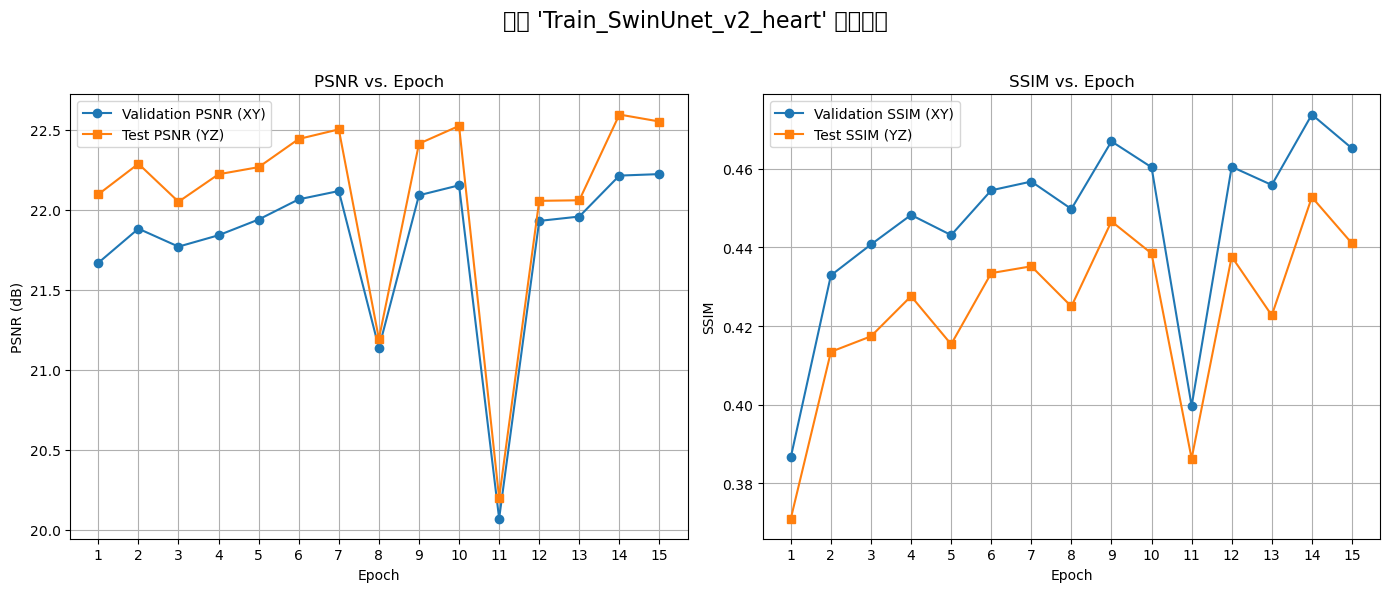

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. 定义模型和 Dataset 类 (与训练时完全一致)
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4, d4 = self.up4(e4), self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        u3, d3 = self.up3(d4), self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        u2, d2 = self.up2(d3), self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
checkpoint_dir = "Train_SwinUnet_v2_heart" # <-- 使用SwinUnet的权重文件夹
num_epochs = 15

# 准备 Dataloaders
val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 定义评估函数
# ----------------------------------------
def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t, tgt_t = inp_t.to(device), tgt_t.to(device)
            out_t = model(inp_t)
            
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.cpu().squeeze().numpy()
            
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            n += 1
    return total_psnr / n, total_ssim / n

# ----------------------------------------
# 4. 循环评估所有Epoch并记录结果
# ----------------------------------------
epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

print(f"开始在 {device} 上评估 '{checkpoint_dir}' 的所有模型...")

for epoch in tqdm(epochs, desc="评估进度"):
    # 构建权重文件路径，注意文件名格式
    ckpt_path = os.path.join(checkpoint_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    
    # 实例化新模型并加载权重
    model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    
    # 在验证集和测试集上评估
    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)
    
    # 记录结果
    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

# ----------------------------------------
# 5. 打印表格形式的结果
# ----------------------------------------
print("\n--- 评估结果汇总 ---")
print("="*60)
print(f"{'Epoch':<10}{'Val PSNR':<15}{'Val SSIM':<15}{'Test PSNR':<15}{'Test SSIM':<15}")
print("-"*60)
for i in range(num_epochs):
    print(f"{i+1:<10}{val_psnrs[i]:<15.4f}{val_ssims[i]:<15.4f}{test_psnrs[i]:<15.4f}{test_ssims[i]:<15.4f}")
print("="*60)


# ----------------------------------------
# 6. 绘制结果图表
# ----------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_psnrs, 'o-', label='Validation PSNR (XY)')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR (YZ)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_ssims, 'o-', label='Validation SSIM (XY)')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM (YZ)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.suptitle(f"模型 '{checkpoint_dir}' 性能评估", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import timm
from torchvision import transforms

# ----------------------------------------
# 1. 定义与训练时完全一致的模型架构
# ----------------------------------------
# 确保这些定义与您训练模型时的代码完全相同
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
# 假设 block32_yz_003.jpg 在 "test_patches_YZ" 文件夹中
IMAGE_PATH = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz\block16_yz_003.jpg"
CHECKPOINT_DIR = "Train_SwinUnet_v2_heart"
EPOCH_TO_LOAD = 15
OUTPUT_DIR = "heart_test"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# ----------------------------------------
# 3. 加载模型权重
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device) # pretrained=False,因为我们要加载自己的权重
checkpoint_filename = f"SwinUnet_v2_hf_epoch{EPOCH_TO_LOAD:02d}.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 加载和预处理图像
# ----------------------------------------
# 加载原始高分辨率图像 (Ground Truth)
gt_image_pil = Image.open(IMAGE_PATH).convert("L")
gt_image_np = np.array(gt_image_pil)
gt_tensor = transform(gt_image_pil).unsqueeze(0).to(device)

print(f"已加载图像: {IMAGE_PATH}")

# 创建模型的低分辨率输入
# 1. 归一化到 [0, 1]
gt_image_float = gt_image_np.astype(np.float32) / 255.0
# 2. 垂直下采样8倍
lr_image_np = cv2.resize(gt_image_float, (256, 32), interpolation=cv2.INTER_AREA)
# 3. 线性插值回原始尺寸
input_image_np = cv2.resize(lr_image_np, (256, 256), interpolation=cv2.INTER_LINEAR)
# 4. 转换为Tensor
input_tensor = torch.from_numpy(input_image_np).unsqueeze(0).unsqueeze(0).to(device)

print("已生成模型的低分辨率输入。")

# ----------------------------------------
# 5. 执行模型推理
# ----------------------------------------
with torch.no_grad():
    output_tensor = model(input_tensor)
print("模型推理完成。")

# ----------------------------------------
# 6. 保存结果图像
# ----------------------------------------
def tensor_to_image(tensor):
    """将 [0,1] 范围的Tensor转换为可保存的PIL Image对象"""
    arr = tensor.clamp(0, 1).cpu().squeeze().numpy()
    return Image.fromarray((arr * 255).round().astype(np.uint8))

# 获取不带后缀的文件名
base_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

# 保存三张图片
path_input = os.path.join(OUTPUT_DIR, f"{base_name}_01_input.png")
path_output = os.path.join(OUTPUT_DIR, f"{base_name}_02_reconstructed.png")
path_gt = os.path.join(OUTPUT_DIR, f"{base_name}_03_ground_truth.png")

tensor_to_image(input_tensor).save(path_input)
tensor_to_image(output_tensor).save(path_output)
tensor_to_image(gt_tensor).save(path_gt)

print(f"\n结果已保存至 '{OUTPUT_DIR}/' 文件夹:")
print(f"  - 输入图像: {path_input}")
print(f"  - 重建图像: {path_output}")
print(f"  - 原始图像: {path_gt}")

C:\Users\Alpaca_YT\anaconda3\envs\mphy0041-cw2-pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_31200\3231550161.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

成功加载模型权重: Train_SwinUnet_v2_heart\SwinUnet_v2_hf_epoch15.pth
已加载图像: C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz\block16_yz_003.jpg
已生成模型的低分辨率输入。
模型推理完成。

结果已保存至 'heart_test/' 文件夹:
  - 输入图像: heart_test\block16_yz_003_01_input.png
  - 重建图像: heart_test\block16_yz_003_02_reconstructed.png
  - 原始图像: heart_test\block16_yz_003_03_ground_truth.png
